# Generate a Noise Model using Bootstrapping

Here we assume that we do not have access to calibration data to create a noise model for training DivNoising. In this case, we use an approach called ```Bootstrapping``` to create a noise model from noisy data itself. The idea is that we will first use the unsupervised denoising method Noise2Void to obtain denoised images corresponding to our noisy data. Then we will treat the denoised images as pseudo GT corresponding to the noisy data and use the pair of noisy images and corresponding Noise2Void denoised images to learn a noise model.

DivNoising when using bootstrapped noise model generally gives better results compared to Noise2Void denoising. Also, unlike Noise2Void, we additionally obtain diverse denoised samples corresponding to any noisy image unlike Noise2Void.

__Note:__ Denoising methods other than Noise2Void can also be used to obtain pseudo GT for bootsrapping a noise model.

In [14]:
import warnings
warnings.filterwarnings('ignore')
import torch
import os
import urllib
import zipfile
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../../')
from divnoising.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from divnoising import histNoiseModel
from divnoising.utils import plotProbabilityDistribution

import torch
import matplotlib.pyplot as plt
import numpy as np
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics_portfolio import PortfolioManager
from PIL import Image

dtype = torch.float
device = torch.device("cuda:0") 

### Load SDTrans data

In [10]:
observation= imread('../../data/SDTrans/noise_200Hz_2400frames_pxlsize30nm_3.90dBSNR_24000x328x328.tif')
#Load the noisy data to be denoised

# load the first 1000 frames
observation = observation[:1000]
print(observation.shape)

(1000, 328, 328)


### Visualize the noisy data

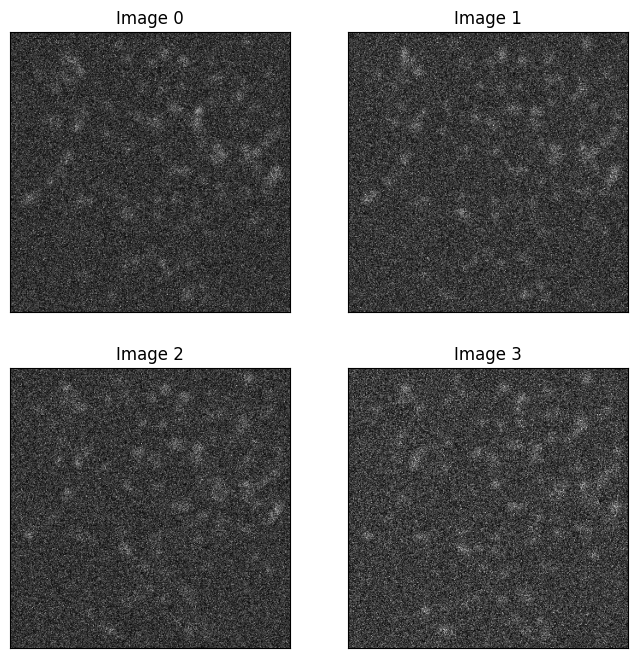

In [11]:
indices=[0,1,2,3]
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(observation[indices[0]], cmap="gray")
ax[0, 0].set_title(f"Image {indices[0]}")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(observation[indices[1]], cmap="gray")
ax[0, 1].set_title(f"Image {indices[1]}")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 0].imshow(observation[indices[2]], cmap="gray")
ax[1, 0].set_title(f"Image {indices[2]}")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(observation[indices[3]], cmap="gray")
ax[1, 1].set_title(f"Image {indices[3]}")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

plt.show()

### Generate pseudo GT

In [16]:
config = create_n2v_configuration(
    experiment_name="SDTrans_n2v",
    data_type="array",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=8,
    num_epochs=10,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1,
                                'use_batch_norm': True},
                      'n2v_config': {'masked_pixel_percentage': 0.2,
                                     'name': 'N2VManipulate',
                                     'remove_center': True,
                                     'roi_size': 11,
                    

### Train the noise model

In [ ]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

train_data=observation

# train
careamist.train(
    train_source=train_data,
)

No working directory provided. Using current working directory: A:\Desktop\SMLM_SR\DivNoising\examples\Mouse_nuclei.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Computed dataset mean: [210.62637098], std: [138.52987974]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 333 K 
-------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.335     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

In [ ]:
loss_dict = careamist.get_losses()
plt.plot(loss_dict["train_epoch"], loss_dict["train_loss"], loss_dict["val_epoch"], loss_dict["val_loss"])
plt.legend(["Train loss", "Val loss"])
plt.title("Losses")

Specify ```path``` where the noisy data will be loaded from. It is the same path where noise model will be stored when created later, ```dataName``` is the name you wish to have for the noise model,  ```n_gaussian``` to indicate how mamny Gaussians willbe used for learning a GMM based noise model, ```n_coeff``` for indicating number of polynomial coefficients will be used to patrametrize the mean, standard deviation and weight of GMM noise model. The default settings for ```n_gaussian``` and ```n_coeff``` generally work well for most datasets.

In [ ]:
path = './data/Mouse_skull_nuclei/'
dataName = 'mouse_skull_nuclei' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [ ]:
nameHistNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
nameGMMNoiseModel = 'GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'bootstrap'

In [ ]:
# Let's look the raw data and our pseudo ground truth signal
print(signal.shape)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='pseudo ground truth')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

### Creating the Histogram Noise Model

Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [ ]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
minVal, maxVal = 2000, 22000
bins = 400

# We are creating the histogram.
# This can take a minute.
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, observation,signal)

# Saving histogram to disc.
np.save(path+nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

In [ ]:
# Let's look at the histogram-based noise model.
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [ ]:
min_signal=np.percentile(signal, 0.5)
max_signal=np.percentile(signal, 99.5)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

In [ ]:
min_signal=np.min(signal)
max_signal=np.max(signal)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Iterating the noise model training for `n_epoch=4000` and `batchSize=25000` works the best for `Mouse nuclei` dataset. 

In [ ]:
gaussianMixtureNoiseModel = GaussianMixtureNoiseModel(min_signal = min_signal, max_signal =max_signal, 
                                                      path=path, weight = None, n_gaussian = n_gaussian, 
                                                      n_coeff = n_coeff, min_sigma = 50, device = device)

In [ ]:
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 25000, n_epochs = 4000, learning_rate=0.1, 
                                name = nameGMMNoiseModel, lowerClip = 0.5, upperClip = 99.5)

### Visualizing the Histogram-based and GMM-based noise models

In [ ]:
plotProbabilityDistribution(signalBinIndex=170, histogram=histogramFD, 
                            gaussianMixtureNoiseModel=gaussianMixtureNoiseModel, min_signal=minVal, 
                            max_signal=maxVal, n_bin= bins, device=device)